# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray
from typing import List, Optional, Tuple, Callable
import random
import copy
import tqdm
from abc import ABC, abstractmethod
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 90

The base `SVM` class below defines a common interface for a support vector machine. 
Your implementations below for each task of the project should inherit from this class. Feel free to add to this class if you need.

In [2]:
class SVM(ABC):
    """Base class for a support vector machine (SVM)"""
    
    def __init__(self) -> None:
        pass
        
    @abstractmethod
    def fit(self, X, y) -> None:        
        """Fit the model with the given training data.
        
        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of training instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        """
        # Check if X and y are numpy.ndarray
        if not isinstance(X, np.ndarray):
            raise ValueError("X must be a numpy.ndarray")

        if not isinstance(y, np.ndarray):
            raise ValueError("X must be a numpy.ndarray")

        # Check if the X's data type is float
        if X.dtype != float:
            raise ValueError("Values in X must have a data type of float")

        # Check if the y's data type is int
        if y.dtype != int:
            raise ValueError("Values in y must have a data type of int and be either -1 or 1")

        # Check if X is a 2D array
        if X.ndim != 2:
            raise ValueError("X must be a 2D array with shape (n_samples, n_features).")

        # Check if y is a vector or a 2D array with a single column
        if y.ndim == 2:
            if y.shape[1] != 1:
                raise ValueError("y must be a vector or a 2D array with a single column.")
        elif y.ndim != 1:
            raise ValueError("y must be a vector or a 2D array with a single column.")

        # Check dimensions compatibility
        if X.shape[0] != y.shape[0]:
            raise ValueError("Number of samples in X and y must be the same.")
    
    @abstractmethod
    def predict(self, test_X) -> int:
        """Predict label for given test samples

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 

        -------
        Return 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Predict labels array for test samples.
        """
        # Check if test_X is a numpy.ndarray
        if not isinstance(test_X, np.ndarray):
            raise ValueError("test_X must be a numpy.ndarray")

        # Check if the input data type is float
        if test_X.dtype != float:
            raise ValueError("Values in test_X must have a data type of float")

        # Check if test_X is a 2D array
        if test_X.ndim != 2:
            raise ValueError("Test dataset must be a 2D array with shape (n_samples, n_features).")
        
    def evaluate(self, test_X, test_y) -> int:
        """Return the mean accuracy on the given test samples and labels.

        Parameters
        ----------        
        test_X : float numpy.ndarray, shape (n_samples, n_features)
            An array of test instances. 
        test_y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to training instances.
        -------
        Return : float, mean accuracy

        """
            
        pred_y = self.predict(test_X)
        acc = (pred_y == test_y).sum() / len(test_y)
        return acc
    
    def visualize(self, X, y) -> None:
        """Plot data and decision surface of fitted model. 
        This function is adapted from 
        https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

        Parameters
        ----------        
        X : float numpy.ndarray, shape (n_samples, n_features)
            An array of instances. 
        y : int {-1,1} numpy.ndarray, shape (n_samples,)
            Labels array relative to X.
        -------
        """
        y = np.array(y).squeeze()
        X = np.array(X)
        
        assert X.ndim == 2, "The shape of X must be (n_samples, n_features)"
        assert X.shape[0] == y.shape[0], "Inconsistent number of instances and labels"
        assert set(y) == set([1,-1]), "Labels must be 1 or -1"
        
        def make_meshgrid(x, y, h=.02):
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(ax, clf, xx, yy, **params):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            out = ax.contourf(xx, yy, Z, **params)
            return out
        
        fig, ax = plt.subplots()
        title = ('Decision surface of SVM')
        # Set-up grid for plotting.
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)

        plot_contours(ax, self, xx, yy, cmap=plt.cm.Pastel1)
        ax.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
        ax.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")

        ax.set_ylabel('$x_1$')
        ax.set_xlabel('$x_2$')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        ax.legend()
        plt.show()

### Binary classification data
We will generate some toy binary classification data, re-using the code from workshop 4. This will be used for tasks 1-3.

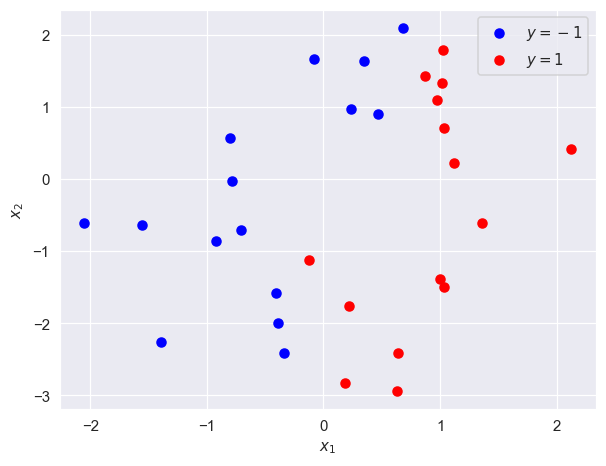

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 30, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
y = np.where(y <=0, -1, 1)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==-1,0], X[y==-1,1], color='b', label="$y = -1$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Task 1: Primal soft-margin SVM

In [26]:
class PrimalSVM(SVM):
    """Soft-margin SVM fit using primal objective, training 
    with stochastic gradient ascent.

    Parameters
    ----------
    eta : float
        Learning rate.
    lambda0: float
        Regularisation term, must be strictly positive
    """
    
    def __init__(self, eta, lambda0) -> None:
        super().__init__()
        ## your code here
        # Check if eta is a float/int and positive
        if not isinstance(eta, (float, int)) or eta <= 0:
            raise ValueError("eta must be a positive float or an int.")

        # Check if lambda0 is a float/int and strictly positive
        if not isinstance(lambda0, (float, int)) or lambda0 <= 0:
            raise ValueError("lambda0 must be a positive float or an int.")

        # Set the values of eta and lambda
        self.eta = eta
        self.lambda0 = lambda0

        self.w = None  # Weight vector
        self.b = None  # Bias term
        ### end of your code ###
        
    def fit(self, X, y, iterations = 100) -> None:
        super().fit(X=X,y=y)
        ## your code here ###
        # Check if iterations is valid
        if not isinstance(iterations, int) or iterations <= 0:
            raise ValueError("iterations must be a positive integer.")

        # Get the shape of X
        n_samples, n_features = X.shape
        self.n_features = n_features

        # Initialize weights w and bias b with very small values
        self.w = np.repeat(0.001, n_features)
        self.b = 0.001

        # Stochastic gradient descent
        # Run training over all training samples for specified iterations
        for _ in range(iterations):
            # Run inner loop over each instance in the training set
            # Update parameters at each training step
            for i in range(n_samples):
                xi = X[i]  # Current training example
                yi = y[i]  # Corresponding label

                # Calculate the loss for the current example
                # Find the hinge loss
                hinge_loss = max(0, 1 - yi * self.__make_predictions(xi))
                # Find the l2-norm of weight vector
                l2_norm = np.linalg.norm(self.w)
                # Add the L2 regularization term to the hinge loss to get the per instance loss
                loss = hinge_loss + 0.5 * self.lambda0 * l2_norm ** 2

                # Update parameters only if the loss is positive
                if loss > 0:
                    # Calculate the gradient of the loss with respect to w and b
                    grad_w = (-yi * xi) + (self.lambda0 * self.w)
                    grad_b = -yi

                    # Update w and b using the gradient and learning rate
                    self.w -= self.eta * grad_w
                    self.b -= self.eta * grad_b

        return
        ### end of your code ###
        
            
    def predict(self, test_X) -> int: 
        super().predict(test_X = test_X)
        ## your code here ###
        # Check if the model has been trained
        if self.w is None or self.b is None:
            raise ValueError("Model not trained. Call fit method first.")

        # Check dimensions compatibility
        if test_X.shape[1] != self.w.shape[0]:
            raise ValueError("Number of features in test_X must match the number of features in the trained model.")

        # Make predictions on test_X
        pred_y = np.sign(self.__make_predictions(test_X))
        return pred_y

    def __make_predictions(self, x):
        """Make a prediction using self.w and self.b on a design matrix.
        Matrix input comprises instances as row vectors.
        Private method.

        Parameters
        ----------
        x: vector or matrix
            design matrix of features with shape (n_samples, n_features) or row vector (1, n_features)

        -------
        Return : Computed prediction as matrix with shape (n_samples, 1) or float

        """
        # Use self.w and self.b to make predictions on x
        pred = np.dot(x, self.w) + self.b
        return pred

        ### end of your code ###

Accuracy is 0.8333


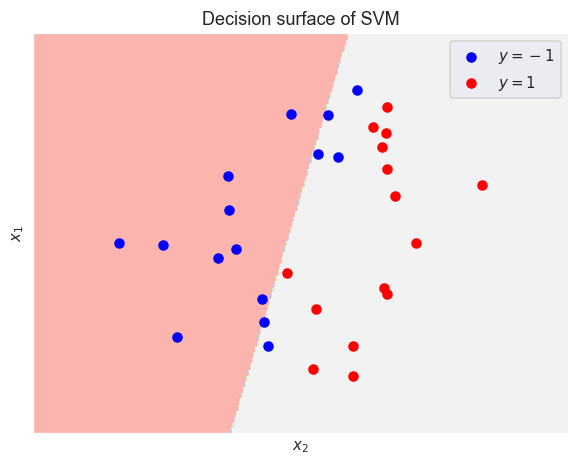

In [27]:
# Initialize the PrimalSVM instance with eta = 0.1 and lambda0 = 0.1
psvm = PrimalSVM(eta = 0.1, lambda0=0.1)

# Train the SVM on the dataset
psvm.fit(X,y, iterations = 100)

# Print the training accuracy
print(f"Accuracy is {round(psvm.evaluate(X,y),4)}")

# Visualize the decision surface and dataset
psvm.visualize(X,y)

### Tuning lambda value

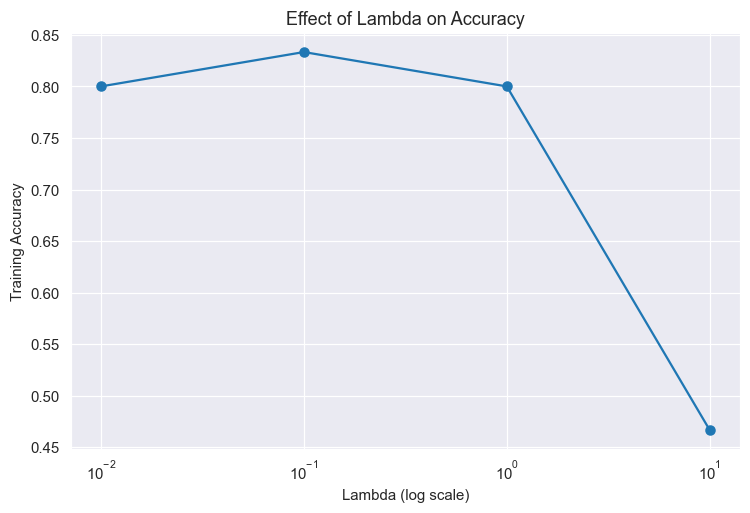

Best Lambda: 0.1, Highest Accuracy: 0.8333


In [29]:
# Use this cell for experimentation 1.b
# Initialize the range of lambda values to test (in logarithmic space)
lambda_values = np.logspace(-2, 1, num=4)

# Initialize list to store accuracy scores
accuracies = []

# Instantiate the PrimalSVM with fixed hyperparameters
eta = 0.1
iterations = 100

# Perform grid search
for lambda0 in lambda_values:
    psvm2 = PrimalSVM(eta=eta, lambda0=lambda0)
    psvm2.fit(X, y, iterations=iterations)
    accuracy = psvm2.evaluate(X, y)
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(8, 5))
plt.semilogx(lambda_values, accuracies, marker='o')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Training Accuracy')
plt.title('Effect of Lambda on Accuracy')
plt.grid(True)
plt.show()

# Find the best lambda value
best_lambda = lambda_values[np.argmax(accuracies)]
print(f"Best Lambda: {best_lambda}, Highest Accuracy: {round(max(accuracies), 4)}")

## Task 2: Dual soft-margin SVM

In [7]:
class DualSVM(SVM):
    """Soft-margin SVM using dual formulation, training 
    with stochastic gradient ascent

    Parameters
    ----------
    eta : float
        Learning rate.
    C: float
        Regularization parameter.
    kernel: Kernel
        Kernel function
    """
    
    def __init__(self, eta, C, kernel = None):
        super().__init__()
        if kernel is None:
            def dot_product(u,v):
                return np.dot(u, v.T)
            self.kernel = dot_product
        else:
            self.kernel = kernel
            
        ## your code here ###
        # Check if eta is a float/int and positive
        if not isinstance(eta, (float, int)) or eta <= 0:
            raise ValueError("eta must be a positive float or an int.")

        # Check if C is a float/int and strictly positive
        if not isinstance(C, (float, int)) or C <= 0:
            raise ValueError("C must be a positive float or an int.")

        # Set the values of eta and lambda
        self.eta = eta
        self.C = C

        self.alphas = None  # Alpha vector
        self.bias = None  # Bias term
        ### end of your code ###
    
    def fit(self, X, y, iterations = 100):
        
        super().fit(X=X,y=y)
        self.X = X
        self.y = y
        
        ### your code here ###
        # Get the shape of X
        n_samples, n_features = X.shape

        # Initialize lagrange multipliers (alphas) with zeros
        self.alphas = np.zeros(n_samples)

        # Stochastic gradient ascent training loop
        for _ in range(iterations):
            # for i in range(n_samples):
            for i in range(n_samples):
                xi = self.X[i]  # Current training example
                yi = self.y[i]  # Corresponding label

                # Calculate the margin
                margin = self.__calculate_margin(x=[xi, self.X])

                # Update alpha_i
                update = self.eta * (1 - yi * margin)
                self.alphas[i] = min(self.C, max(0, self.alphas[i] + update))
        ### end of your code ###
        # Compute the bias
        self.bias = self.get_bias()

        return 
     
    def predict(self, test_X):
        super().predict(test_X=test_X)
        ### your code here ###
        # Check if the model has been trained
        self.__check_trained()

        # Check dimensions compatibility
        if test_X.shape[1] != self.X.shape[1]:
            raise ValueError("Number of features in test_X must match the number of features in the trained model.")

        # Calculate predictions using learned alphas
        preds = np.zeros(test_X.shape[0])
        for i in range(test_X.shape[0]):
            xi = test_X[i]  # Current test example

            pred = np.sign(self.bias + self.__calculate_margin(x=[xi, self.X]))
            preds[i] = pred

        return preds
        ### end of your code ###
    
    def primal_weights(self):
        """Compute weights based on alphas, assuming linear kernel
        """
        ### your code here ###
        # Check if the model has been trained
        self.__check_trained()

        # Calculate primal weights based on learned alphas
        primal_w = np.sum(self.alphas.reshape(-1, 1) * self.y.reshape(-1, 1) * self.X, axis=0)
        return primal_w
        ### end of your code ###
        
    def get_bias(self):
        """Compute bias based on learned alphas and training data set
        """
        ### your code here ###
        # Check if the model has been trained
        self.__check_trained()

        # Initialize an empty list to store the candidate biases
        candidate_biases = []

        # Iterate through all the alphas
        for i in range(len(self.alphas)):
            # Check if the alpha meet the conditions of a candidate
            if 0 < self.alphas[i] < self.C:
                # Calculate the candidate bias for the i-th alpha and append to list
                xi = self.X[i]  # Current example
                candidate_b = self.y[i] - self.__calculate_margin(x=[xi, self.X])
                candidate_biases.append(candidate_b)

        # Return 0 if no candidates
        if not candidate_biases:
            return 0

        # Calculate the final bias as the average of candidate biases
        bias = np.mean(candidate_biases)
        return bias

    def __check_trained(self):
        """
        Checks whether the SVM has been trained before performing predict, primal_weights and get_bias

        Raise : Value Error if subsequent methods are called before calling fit on the model
        """
        # Check if the model has been trained
        if self.alphas is None:
            raise ValueError("Model not trained. Call fit method first.")

    def __calculate_margin(self, x, axis=None):
        """Calculate the kernelised margin used by fit and predict methods.
        Private method.

        Parameters
        ----------
        x: list
            contains [u,v] to be used to evaluate the kernel

        axis: int
            axis along which to perform summation
        -------
        Return : Computed dual margin
        """
        # Calculate the margin
        margin = np.sum(self.alphas * self.y * self.kernel(x[0], x[1]))
        return margin

        ### end of your code ###

Accuracy is 0.9667


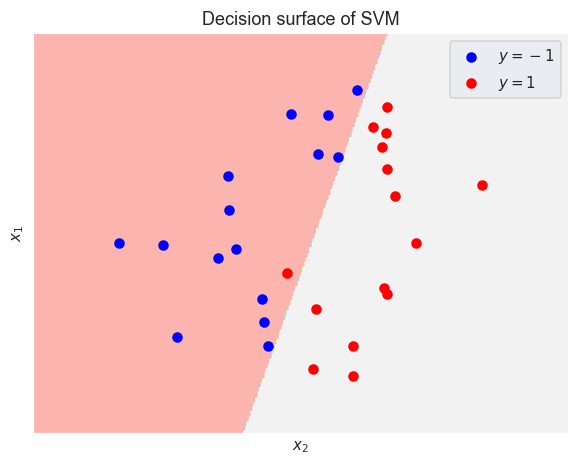

In [8]:
dsvm = DualSVM(eta = 0.1, C = 100)
dsvm.fit(X,y, iterations = 100)
print(f"Accuracy is {round(dsvm.evaluate(X,y),4)}")
dsvm.visualize(X,y)

### Tuning C value

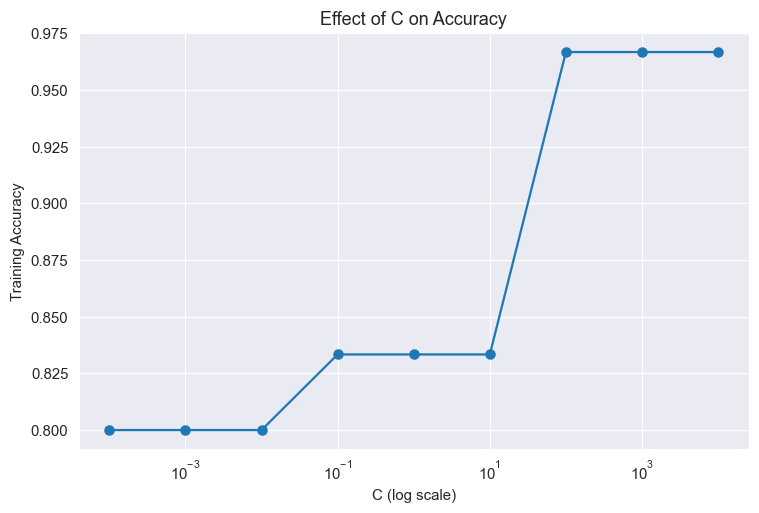

Best C: 100.0, Highest Accuracy: 0.9666666666666667


In [9]:
# Use this cell here for experimentation 2.a
# Initialize the range of C values to test (in logarithmic space)
C_values = np.logspace(-4, 4, num=9)

# Initialize list to store accuracy scores
accuracies = []

# Instantiate the DualSVM with fixed hyperparameters
eta = 0.1
iterations = 100

# Perform grid search
for C in C_values:
    dsvm = DualSVM(eta=eta, C=C)
    dsvm.fit(X, y, iterations=iterations)
    accuracy = dsvm.evaluate(X, y)
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(8, 5))
plt.semilogx(C_values, accuracies, marker='o')
plt.xlabel('C (log scale)')
plt.ylabel('Training Accuracy')
plt.title('Effect of C on Accuracy')
plt.grid(True)
plt.show()

# Find the best lambda value
best_C = C_values[np.argmax(accuracies)]
print(f"Best C: {best_C}, Highest Accuracy: {max(accuracies)}")

### Compare weights between primal and dual

In [19]:
# Use this cell here for experimentation 2.b
# Train the DualSVM model with specified hyperparameters
dsvm = DualSVM(eta=0.1, C=100)
dsvm.fit(X, y, iterations=100)

# Compute the equivalent primal weights from the DualSVM
dual_weights = dsvm.primal_weights()

# Train a PrimalSVM model with equivalent hyperparameters (lambda=1/C)
primal_lambda = 1 / dsvm.C
psvm = PrimalSVM(eta=0.1, lambda0=primal_lambda)
psvm.fit(X, y, iterations=100)

# Compute the weights for the PrimalSVM
primal_weights = psvm.w

# Calculate the norm of the difference between dual and primal weights
weight_difference_norm = np.linalg.norm(dual_weights - primal_weights)

# Print the result
print(f"Norm of the difference between dual and primal weights: {weight_difference_norm}")

Norm of the difference between dual and primal weights: 65.78733792533923


### Identify support vectors and points where alpha=C

Support Vectors:
[ 0  2  3  6  7  8  9 10 16 18 20 22 23 24 26 29]

Points where alpha = C:
[]


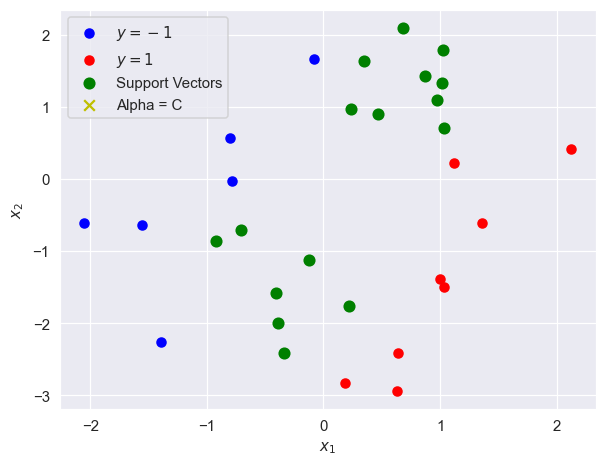

In [11]:
# Use this cell here for experimentation 2.c
# Train the DualSVM model with specified hyperparameters
dsvm = DualSVM(eta=0.1, C=100)
dsvm.fit(X, y, iterations=100)

# Get the Lagrange multipliers (alphas)
alphas = dsvm.alphas

# Find the indices where alpha equals C (0 < alpha < C are support vectors)
support_vector_indices = np.where((alphas > 0) & (alphas < dsvm.C))[0]
alpha_c_indices = np.where(alphas == dsvm.C)[0]

# Print the results
print("Support Vectors:")
print(support_vector_indices)

print("\nPoints where alpha = C:")
print(alpha_c_indices)

# Create a scatter plot of the dataset
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='b', label="$y = -1$")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='r', label="$y = 1$")

# Highlight support vectors with a different marker
plt.scatter(X[support_vector_indices, 0], X[support_vector_indices, 1], color='g', marker='o', s=50, label="Support Vectors")

# Highlight points where alpha = C with a different marker
plt.scatter(X[alpha_c_indices, 0], X[alpha_c_indices, 1], color='y', marker='x', s=50, label="Alpha = C")

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## Task 3: Kernel

In [12]:
from numpy.linalg import norm

    
class Kernel():
    """Kernel class

    Parameters
    ----------
    kernel_type : str {linear, poly, rbf}
        Type of kernel be indicated.
    poly_degree: int
        Polynomial degree for polynormial kernel. 
    poly_offset: float
        Polynomial offset for polynomial kernel. 
    rbf_sigma: float
        Kernel coefficient for rbf kernel. 
    """
    
    def __init__(self, kernel_type = None, **kwargs):
        if kernel_type == "linear":
            self.kernel = self.linear_kernel
        if kernel_type == "poly":
            self.degree = kwargs.get('poly_degree')
            self.sigma = kwargs.get('poly_offset')
            self.kernel = self.poly_kernel
        if kernel_type == "rbf":
            self.sigma = kwargs.get('rbf_sigma')
            self.kernel = self.rbf_kernel
            
    def __call__(self,u,v):
        """Evaluate the kernel on a pair of inputs, possibly batched.
        Matrix input is comprised of instances as row vectors.

        Parameters
        ----------
        u: vector or matrix
            first instance(s), shape (n,) or (m,n)
        v: vector or matrix
            second instance(s), shape (n,) or (z,n)
        
        -------
        Return : Kernel matrix, float or shape(z,) or shape (m,z)

        """
        # Ensure that u and v are matrices (instances as row vectors)
        if u.ndim == 1:
            u = u.reshape(1, -1)
        if v.ndim == 1:
            v = v.reshape(1, -1)

        return self.kernel(u, v)
        
    def linear_kernel(self, u, v):
        return np.dot(u,v.T)

    def poly_kernel(self, u, v):
        ### your code here ###
        # Compute the polynomial kernel with the specified degree and offset
        return (np.dot(u, v.T) + self.sigma) ** self.degree
        ### end of your code ###

    def rbf_kernel(self, u, v):
        ### your code here ###
        # Calculate the squared-norm of u-v
        norm_squared = np.sum((u[:, np.newaxis] - v) ** 2, axis=-1)
        # Compute the RBF kernel with the specified sigma
        return np.exp(-norm_squared / (2 * self.sigma ** 2))
        ### end of your code ###

### Test your kernel in the DualSVM

Accuracy (Linear Kernel): 0.9667
Accuracy (Polynomial Kernel): 0.8333
Accuracy (RBF Kernel): 1.0


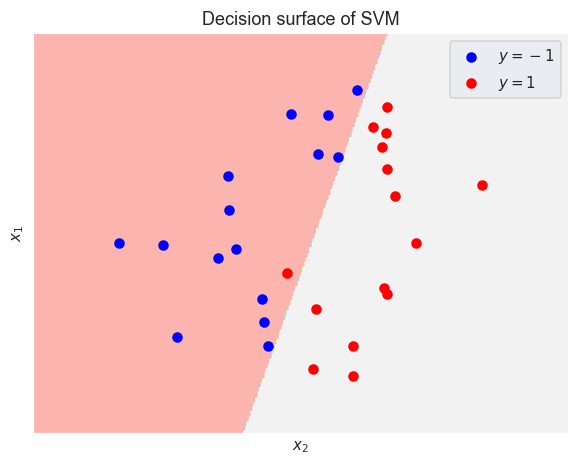

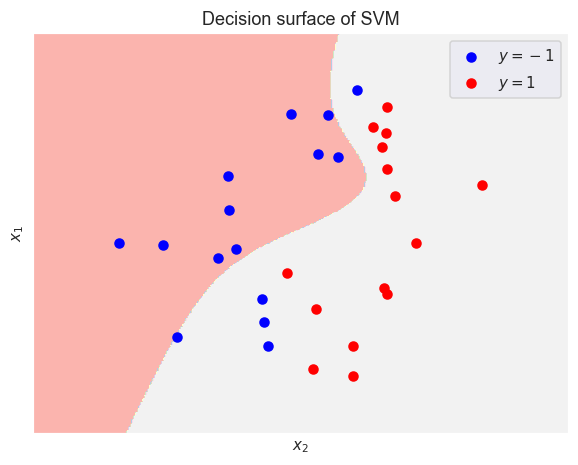

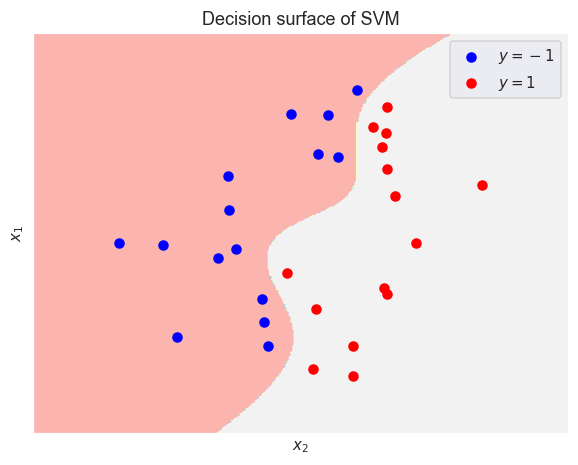

In [13]:
# Use this cell here for experimentation 3, e.g., 
# Create instances of the DualSVM with different kernels
dsvm_linear = DualSVM(eta=0.1, C=100, kernel=Kernel('linear'))
dsvm_poly = DualSVM(eta=0.1, C=100, kernel=Kernel('poly', poly_degree=3, poly_offset=1.722))
dsvm_rbf = DualSVM(eta=0.1, C=100, kernel=Kernel('rbf', rbf_sigma=1))

# Fit the models to the dataset
dsvm_linear.fit(X, y, iterations=100)
dsvm_poly.fit(X, y, iterations=100)
dsvm_rbf.fit(X, y, iterations=100)

# Print the accuracies
acc_linear = dsvm_linear.evaluate(X, y)
acc_poly = dsvm_poly.evaluate(X, y)
acc_rbf = dsvm_rbf.evaluate(X, y)

print(f"Accuracy (Linear Kernel): {round(acc_linear, 4)}")
print(f"Accuracy (Polynomial Kernel): {round(acc_poly, 4)}")
print(f"Accuracy (RBF Kernel): {round(acc_rbf, 4)}")

# Visualize the decision boundaries for each kernel
dsvm_linear.visualize(X, y)
dsvm_poly.visualize(X, y)
dsvm_rbf.visualize(X, y)

[In a few sentences, explain which kernel you think is best suited to this problem, and why.]